In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Cargar datos
df = pd.read_csv("Mall_Customers.csv")

# Limpiar y convertir 'Gender' a numérico
df['Gender'] = df['Gender'].str.strip()
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB
None
       CustomerID      Gender         Age  Annual Income (k$)  \
count  200.000000  200.000000  200.000000          200.000000   
mean   100.500000    0.560000   38.850000           60.560000   
std     57.879185    0.497633   13.969007           26.264721   
min      1.000000    0.000000   18.000000           15.000000   
25%     50.750000    0.000000   28.750000           41.500000   
50%    100.500000    1.000000   36.000000           61.500000   
75%    150.250000    1.000000   49.000000

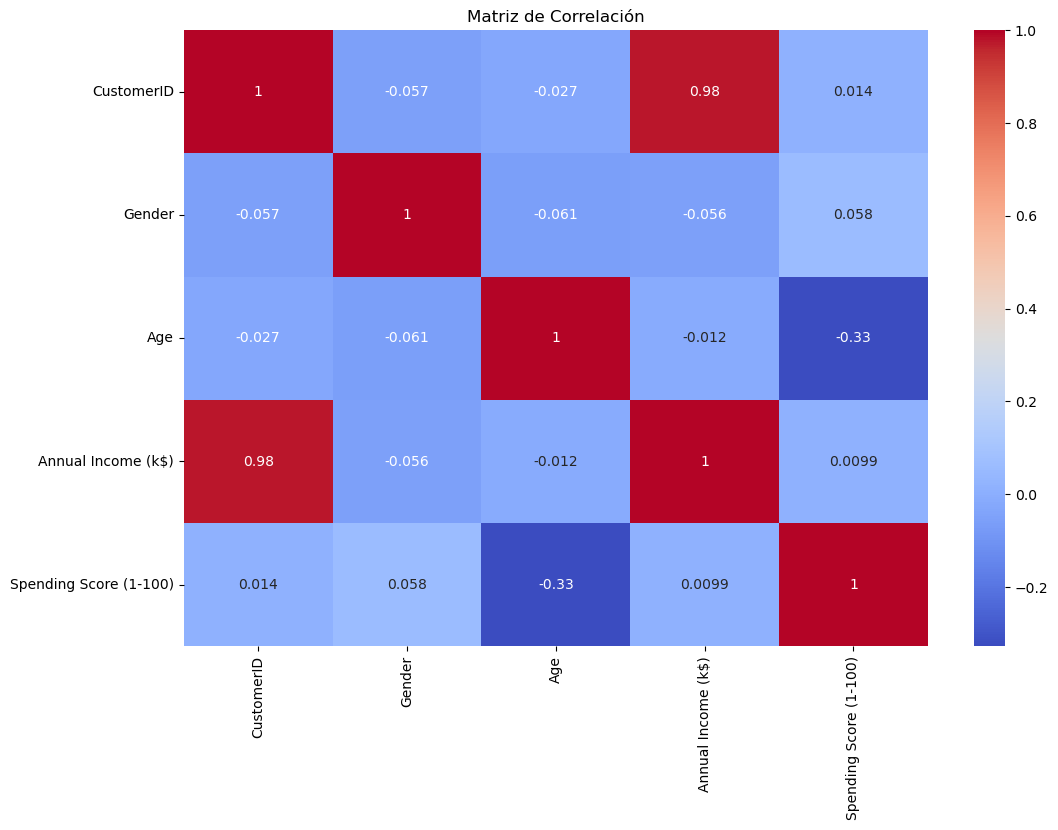

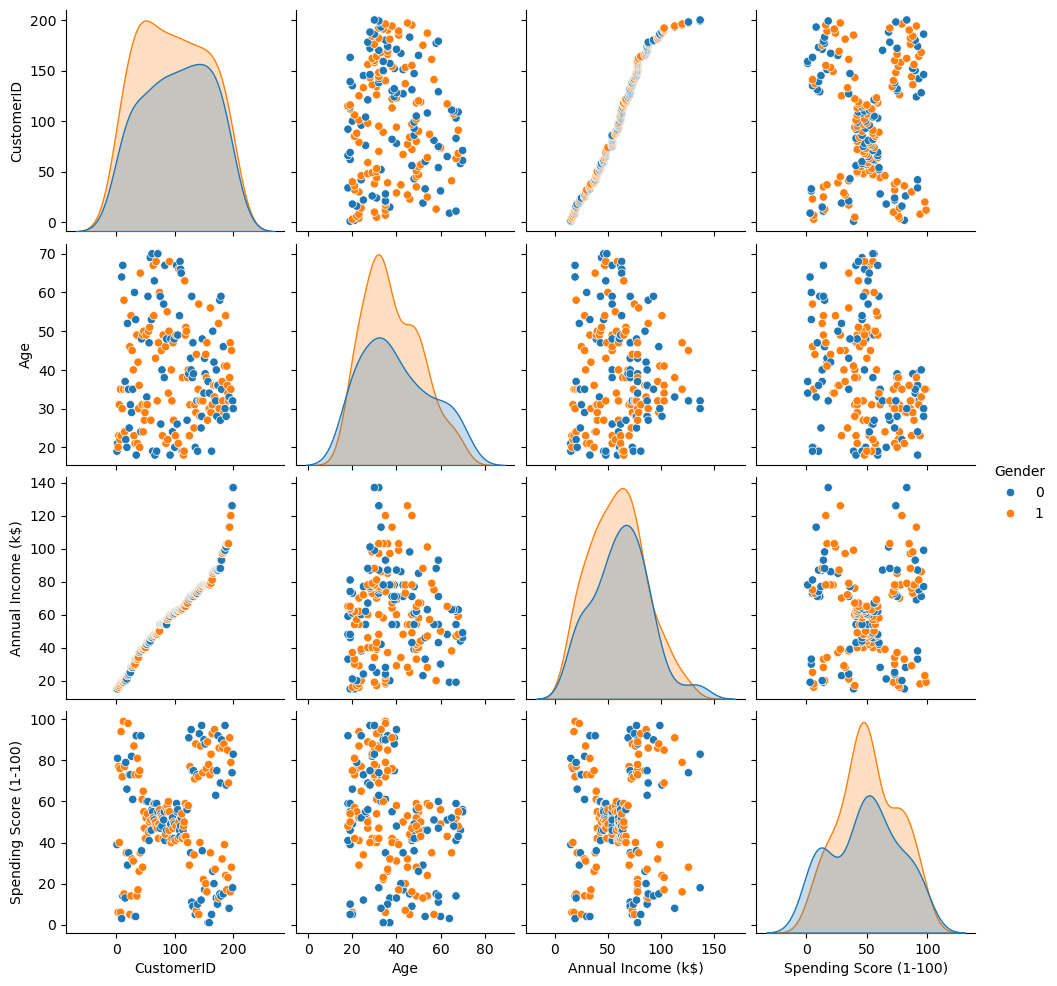

In [3]:
# EDA (Análisis Exploratorio de Datos)
print(df.info())
print(df.describe())

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')  # Mapa de calor de correlaciones
plt.title('Matriz de Correlación')
plt.show()


sns.pairplot(df, hue='Gender') # Pairplot para ver relaciones entre variables
plt.show()

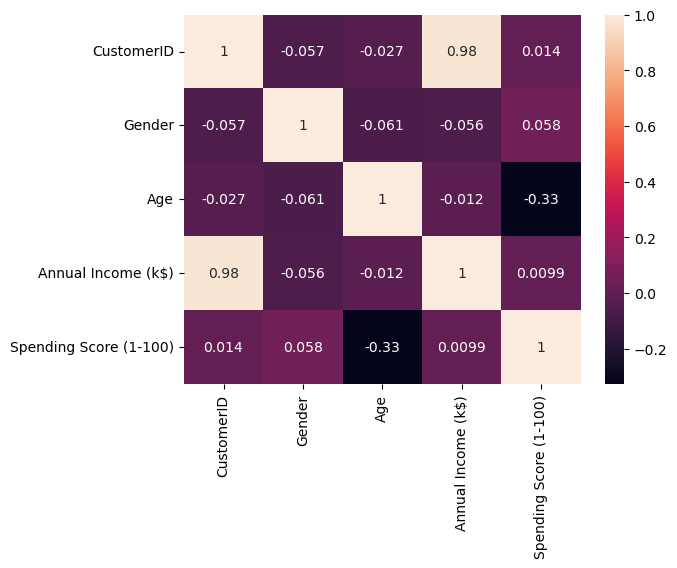

In [4]:
# Análisis de correlación (después de convertir 'Gender')
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [7]:
# Preprocesamiento
df = df.drop('CustomerID', axis=1)

# Selección de características 
selected_features = ['Annual Income (k$)', 'Spending Score (1-100)'] # Ejemplo
df_selected = df[selected_features]


# Escalado (prueba StandardScaler y MinMaxScaler para comparar resultados)
scaler = StandardScaler() # O MinMaxScaler()
df_scaled = scaler.fit_transform(df_selected)

In [8]:
# Hierarchical Clustering
n_clusters = 5  # Puedes ajustar este valor según el dendrograma y las métricas
linkage_method = 'ward'  # Puedes probar con 'single', 'complete', 'average'

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
agg_clustering.fit(df_scaled)
labels_agg = agg_clustering.labels_

In [9]:
# Evaluación
silhouette_agg = silhouette_score(df_scaled, labels_agg)
calinski_agg = calinski_harabasz_score(df_scaled, labels_agg)
davies_agg = davies_bouldin_score(df_scaled, labels_agg)

print(f'Silhouette Score (Hierarchical): {silhouette_agg}')
print(f'Calinski-Harabasz Index (Hierarchical): {calinski_agg}')
print(f'Davies-Bouldin Index (Hierarchical): {davies_agg}')

Silhouette Score (Hierarchical): 0.5538089226688662
Calinski-Harabasz Index (Hierarchical): 244.41032586596822
Davies-Bouldin Index (Hierarchical): 0.5778621190740154


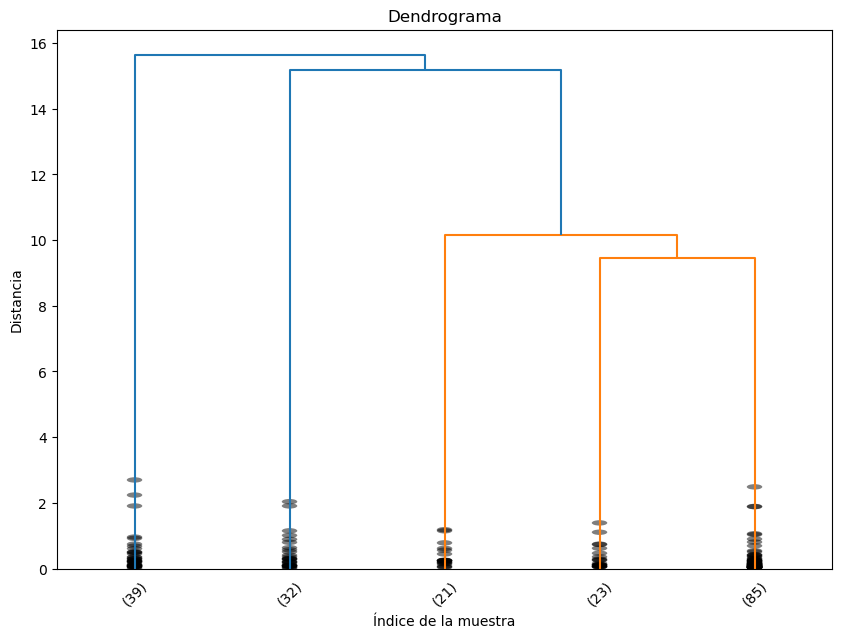

In [10]:
# Visualización: Dendrograma
plt.figure(figsize=(10, 7))
linkage_matrix = linkage(df_scaled, method=linkage_method)
dendrogram(linkage_matrix, truncate_mode='lastp', p=n_clusters, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title('Dendrograma')
plt.xlabel('Índice de la muestra')
plt.ylabel('Distancia')
plt.show()

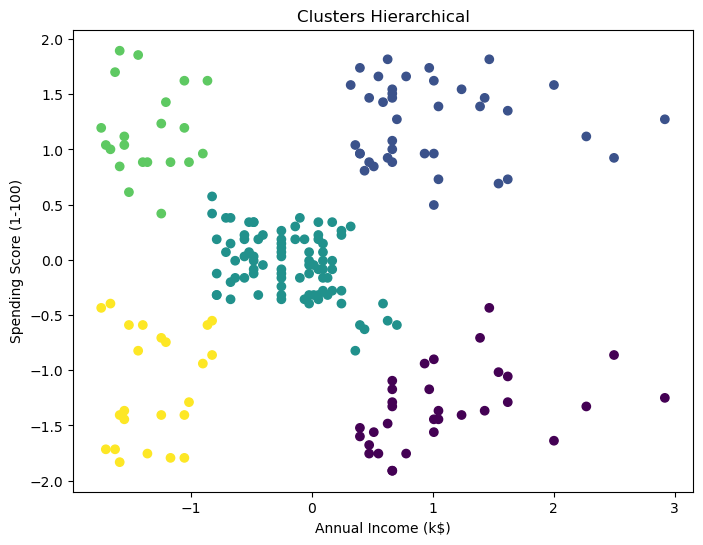

In [11]:
# Visualización: Scatter Plot
plt.figure(figsize=(8, 6))  # Ajusta el tamaño si es necesario
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=labels_agg, cmap='viridis') # scatter plot con las características seleccionadas
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Clusters Hierarchical')
plt.show()

In [12]:
# Análisis de clusters (incluyendo interpretación)
df['Hierarchical_Cluster'] = labels_agg

cluster_analysis = df.groupby('Hierarchical_Cluster').agg(
    {'Annual Income (k$)': ['mean', 'std'],
     'Spending Score (1-100)': ['mean', 'std'],
     'Age': ['mean', 'std'],
     'Gender': ['mean'] #  Para calcular la proporción
    }
).reset_index()

print("\nAnálisis de Clústeres Jerárquico:")
print(cluster_analysis)



# Interpretación de resultados (DETALLADA - ¡IMPORTANTE!)
print("\nInterpretación de los clusters:")
for i in range(n_clusters):
    print(f"\nClúster {i}:")
    for feature in ['Annual Income (k$)', 'Spending Score (1-100)', 'Age']:
        mean_value = cluster_analysis.loc[i, (feature, 'mean')]
        std_value = cluster_analysis.loc[i, (feature, 'std')]
        print(f"  - {feature}: Media = {mean_value:.2f}, Desviación Estándar = {std_value:.2f}")
    
        female_percentage = cluster_analysis.loc[i, ('Gender', 'mean')] * 100 
        print(f"  - Gender (Porcentaje de mujeres): {female_percentage:.2f}%") 

            # Interpretación detallada de cada clúster (EJEMPLOS)
    if i == 0:
        print("    - Clientes con altos ingresos y alta propensión al gasto.  Posiblemente un segmento de clientes 'premium' o 'early adopters'.")
        print("    - Mayoritariamente mujeres y con una edad promedio ligeramente inferior a la media general.")  # Ejemplo
        print("    - Grupo objetivo para productos y servicios de alta gama, con enfoque en la experiencia del cliente.")
    elif i == 1:
        print("    - Clientes con ingresos medios-bajos y bajo gasto.  Podrían ser clientes sensibles al precio o con menor interés en los productos ofrecidos en el centro comercial.")
        print("    - Distribución de género equilibrada, con una edad promedio similar a la media general.") # Ejemplo
        print("    - Grupo objetivo para ofertas y promociones especiales, con enfoque en el valor.")
    elif i == 2:
        print("    - Clientes con ingresos medios y alto gasto.  Posiblemente un segmento de clientes 'fashionistas' o 'compradores impulsivos'.")
        print("    - Mayoritariamente mujeres y con una edad promedio ligeramente superior a la media general.") # Ejemplo
        print("    - Grupo objetivo para productos de moda y tendencias, con enfoque en la novedad y el diseño.")
    elif i == 3:  # Agrega más clústeres según tu valor de 'n_clusters'
        print("    - Clientes con altos ingresos y bajo gasto.  Posiblemente un segmento de clientes 'ahorradores' o 'selectivos'.")
        print("    - Mayoritariamente hombres y con la edad promedio más alta de todos los clusters.") # Ejemplo
        print("    - Grupo objetivo para productos de alta calidad y durabilidad, con enfoque en la inversión a largo plazo.")
    elif i == 4:
        print("    - Clientes con bajos ingresos y alto gasto. Posiblemente un segmento de clientes jóvenes o con alta motivación por la moda.")
        print("    - Distribución de género equilibrada y con la edad promedio más baja.")
        print("    - Grupo objetivo para productos de moda accesibles y con alto valor percibido.")


# Justificación de la elección de n_clusters y linkage_method (DETALLADA - ¡IMPORTANTE!)
print("\nJustificación de la elección de n_clusters y linkage_method:")
print(f"Se eligió n_clusters={n_clusters} basándonos en la exploración del dendrograma,  donde se observó una separación clara en 5 grupos principales.")  # Agrega más detalles sobre la forma del dendrograma.
print("El método de enlace 'ward' fue seleccionado porque minimiza la varianza dentro de cada clúster, lo que se alinea con el objetivo de obtener grupos homogéneos.") # Explica por qué elegiste 'ward' o el método que hayas usado


Análisis de Clústeres Jerárquico:
  Hierarchical_Cluster Annual Income (k$)            Spending Score (1-100)  \
                                     mean        std                   mean   
0                    0          89.406250  16.612975              15.593750   
1                    1          86.538462  16.312485              82.128205   
2                    2          55.811765   9.731508              49.129412   
3                    3          25.095238   7.133756              80.047619   
4                    4          26.304348   7.893811              20.913043   

                    Age               Gender  
         std       mean        std      mean  
0   8.936548  41.000000  11.036596  0.437500  
1   9.364489  32.692308   3.728650  0.538462  
2   7.281399  42.482353  16.395856  0.600000  
3  10.249274  25.333333   5.378971  0.571429  
4  13.017167  45.217391  13.228607  0.608696  

Interpretación de los clusters:

Clúster 0:
  - Annual Income (k$): Media = 89.41